In [213]:
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import glob
import torch
import numpy as np
import random
import torchvision.transforms.functional as TF
import PIL.Image as Image

In [233]:
def get_image_metadata(path_to_file):
    """Function for extracting metadata from filename of dataset provided by AstraZeneca.
    
    B02   - well (row B, column 02) 
    T0001 - timepoint (irrelevant for this dataset) 
    F001  - field of view = site 
    L01   - timeline (irrelevant for this datset) 
    A01   - action list number (3 fluorescent + 1 brightfield action) 
    Z01   - 3D z-number (slice number or vertical position) 
    C01   - imaging channel (1 nuclear, 2 lipids, 3 cytoplasm, 4 brightfield)

    """
    string_arr = os.path.basename(path_to_file).split("_")
    row_col = string_arr[-2] # Row and column
    fied_of_view = string_arr[-1][5:9]
    action_list_number = string_arr[-1][12:15]
    z_number_3d = string_arr[-1][15:18]
    imaging_channel = string_arr[-1][18:21]
    is_mask = "mask" in path_to_file
    return {
        "row_col":       row_col,
        "field of view": fied_of_view,
        "action_list_number": action_list_number,
        "z_number_3d": z_number_3d,
        "imaging_channel": imaging_channel,
        "path": path_to_file,
        "is_mask": is_mask
    }

class ExampleDataset(Dataset):

    def __init__(self, dataset_path, crop_size=(256,256), transform=None):
        """Example dataset for sample images for the Astra Zeneca competition
        
        Group by row_col and field of view
        # row_col
        # field of view
         
        Input and Target share these common values:
        - row_col       = sample id? 
        - field of view = amount of zoom

        For identifying INPUT:
        - action_list_number A04
        - imaging_channel    C04
        - z_number_3d        Z01 - Z07

        For identifying TARGET:
        - action_list_number A01 A02 and A03
        - imaging_channel    C01, C02, C03
        - z_number_3d        Z01
        """
        self.dataset_path = dataset_path
        
        dataset_samples = glob.glob(os.path.join(self.dataset_path, "*/*/Assay*"))

        dataset_dicts = [get_image_metadata(path) for path in dataset_samples]
        
        # Group all 7 inputs with all 3 respective targets into variable sample
        samples = dict()
        for sample_dict in dataset_dicts:
            sample_key = (sample_dict["row_col"], sample_dict["field of view"])

            if samples.get(sample_key) is None:
                samples[sample_key] = {
                    "input": dict(),
                    "target": dict(),
                    "mask" : dict()
                }

            if sample_dict["action_list_number"] == "A04":
                # Is an input
                z_number_3d = sample_dict["z_number_3d"]
                samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
            elif sample_dict["is_mask"]:
                # Is a mask
                action_list_number = sample_dict["action_list_number"]
                samples[sample_key]["mask"][action_list_number] = sample_dict["path"]
            else:
                # Is a target
                action_list_number = sample_dict["action_list_number"]
                samples[sample_key]["target"][action_list_number] = sample_dict["path"]                

        self.samples = list(samples.values())
        self.crop_size = crop_size
        self.transforms = transform
        
    def __len__(self):
        #return len(self.samples)
        return 200
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Modulo
        idx = idx % len(self.samples)

        sample_dict = self.samples[idx]
        w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
        assert self.crop_size[0] <= w
        assert self.crop_size[1] <= h

        input = np.zeros((7, w, h))
        output = np.zeros((3, w, h))
        mask = np.zeros((3, w, h), dtype = 'int16') # As masks will be binary
        for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
            img_path = sample_dict["input"][z_number_3d]
            img = cv2.imread(img_path, -1)
            img = img.astype(np.int16)
            input[i] = img

        for i, action_list_number in enumerate(["A01", "A02", "A03"]):
            img_path = sample_dict["target"][action_list_number]
            img = cv2.imread(img_path, -1)
            img = img.astype(np.int16)
            output[i] = img
        
        # add real nuclei mask -- saved as pickle because of problems... ---- /Isabella
        import pickle
        mask_path = sample_dict["mask"]["A01"]
        m = pickle.load(open(mask_path, "rb"))
        # This code should stay:
        mask[0] = m

        if self.transforms:
            for transform in self.transforms: 
                input, output, mask = transform(input, output, mask)

        return input, output, mask

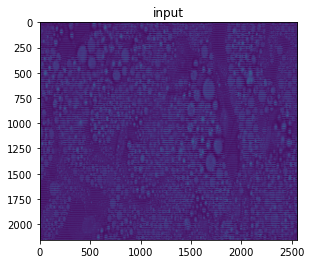

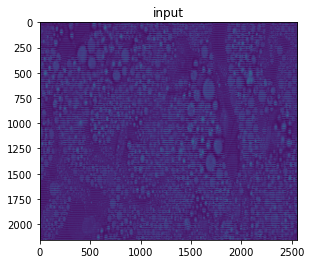

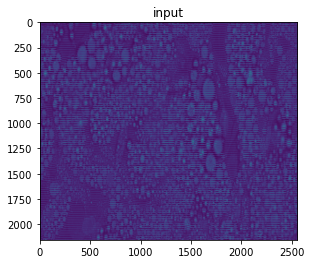

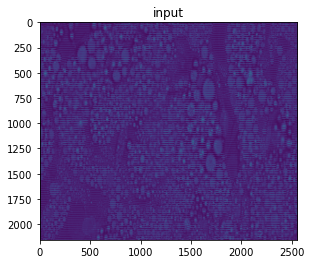

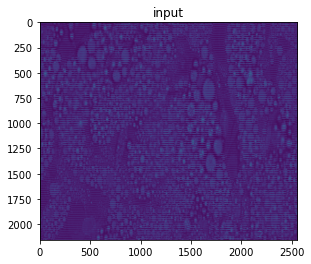

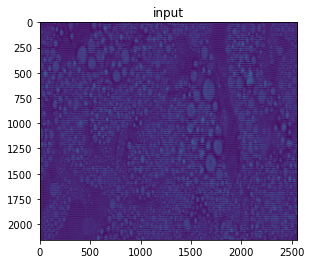

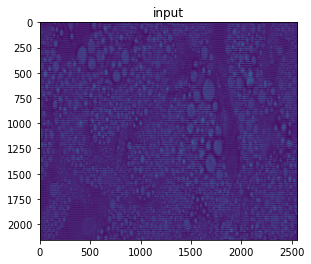

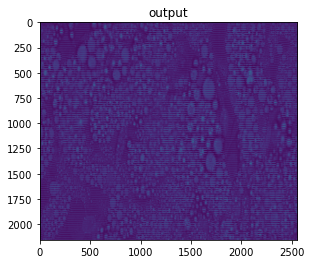

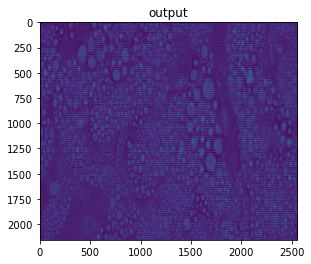

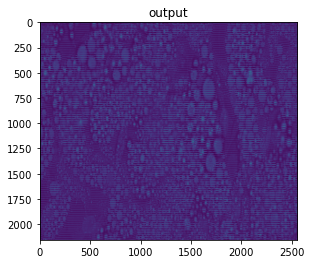

In [305]:
def visualize_results(x, title = ""):
    for img in x:
        plt.figure()
        plt.imshow(img)
        plt.title(title)

def stack(augmentation):
    def wrapper(self, input, target, mask):
        # Stack targets on inputs
        stacked_inputs = np.append(input, target, axis = 0)
        # Transform
        augs = augmentation(self, stacked_inputs, mask)
        # Unpack
        stacked_inputs, mask = augs['image'], augs['mask']
        # I thought this code below should be [:7] then [7:], but the channels are shuffled
        # somehow in the augmentation hflip and vflip
        input = stacked_inputs[3:]
        target = stacked_inputs[:3]
        return input, target, mask
    return wrapper

class Normalize:

    def __init__(self):
        self.transform = A.ToFloat(max_value=65535.0)

    def __call__(self, input, target, mask):
        input = self.transform(image = input)['image']
        target = self.transform(image = target)['image']
        return input, target, mask

class VerticalFlip:

    def __init__(self, p = 0.5):
        self.transform = A.VerticalFlip(p=p)

    @stack
    def __call__(self, inputs, mask):
        return self.transform(image = inputs, mask = mask)

class HorizontalFlip:

    def __init__(self, p = 0.5):
        self.transform = A.HorizontalFlip(p=p)

    @stack
    def __call__(self, inputs, mask):
        return self.transform(image = inputs, mask = mask)

class Rotate:

    def __init__(self, p = 0.5, limit = 89):
        self.transform = A.Rotate(limit = limit, p=p)

    @stack
    def __call__(self, inputs, mask):
        return self.transform(image = inputs, mask = mask)

norm = Normalize()
vflip = VerticalFlip(p=1) # set P = 1 so that we see that the augmentations run every time
hflip = HorizontalFlip(p=1) # set P = 1 so that we see that the augmentations run every time
rotate = Rotate(p=1)

data_transforms = A.Compose([
  norm,
  #vflip,
  #hflip,
  rotate
  ])

AZdset = ExampleDataset(r"C:\Users\IsabellaGagner\Documents\astra-zeneca-hackathon\images_for_preview", crop_size=(512,512), transform = data_transforms)

input, output, mask = AZdset[2]
visualize_results(input, title = "input")
visualize_results(output, title = "output")
#visualize_results(mask)

#AZdset_dataloader = DataLoader(dataset=AZdset, batch_size=2)
#x, y, z = next(iter(AZdset_dataloader))
#print(x.shape, y.shape)

